In [20]:
from tqdm import tqdm
import datetime
tqdm.pandas()
#connect local PATH
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
btc=get_btc_actual_hourly()
import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



100%|██████████| 30907/30907 [00:00<00:00, 163964.38it/s]


In [2]:
import pandas as pd
subs=pd.read_pickle(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Datasets Heisenberg\submissions_heisenberg.pickle")

In [ ]:

bdf=subs[subs.topic=='Bitcoin']
bdf['volume']=1
bdf['buy_sell']=bdf.buy^bdf.sell

features=['sent_db',
 'sent_fb',
 'sent_lr',
 'sent_ntusd',
 'sent_fbt',
 'buy',
 'sell',
 'volume',
 'sent_ntusd_coms',
 'buy_sell',
 'close']



In [156]:
resample_period='d'
s1=bdf.sent_db.resample(resample_period).sum()
s2=bdf.sent_fb.resample(resample_period).sum()
s3=bdf.sent_lr.resample(resample_period).sum()
s4=bdf.sent_ntusd.resample(resample_period).sum()
s5=bdf.sent_fbt.resample(resample_period).sum()
s6=bdf.buy.resample(resample_period).sum()
s7=bdf.sell.resample(resample_period).sum()
s8=bdf.volume.resample(resample_period).sum()
s9=bdf.sent_ntusd_coms.resample(resample_period).sum()
s10=bdf.buy_sell.resample(resample_period).sum()

btcin=btc.resample(resample_period).mean()#.pct_change().dropna()

a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btcin],axis=1)
a=a[~a.sent_fbt.isna()].head(-1)

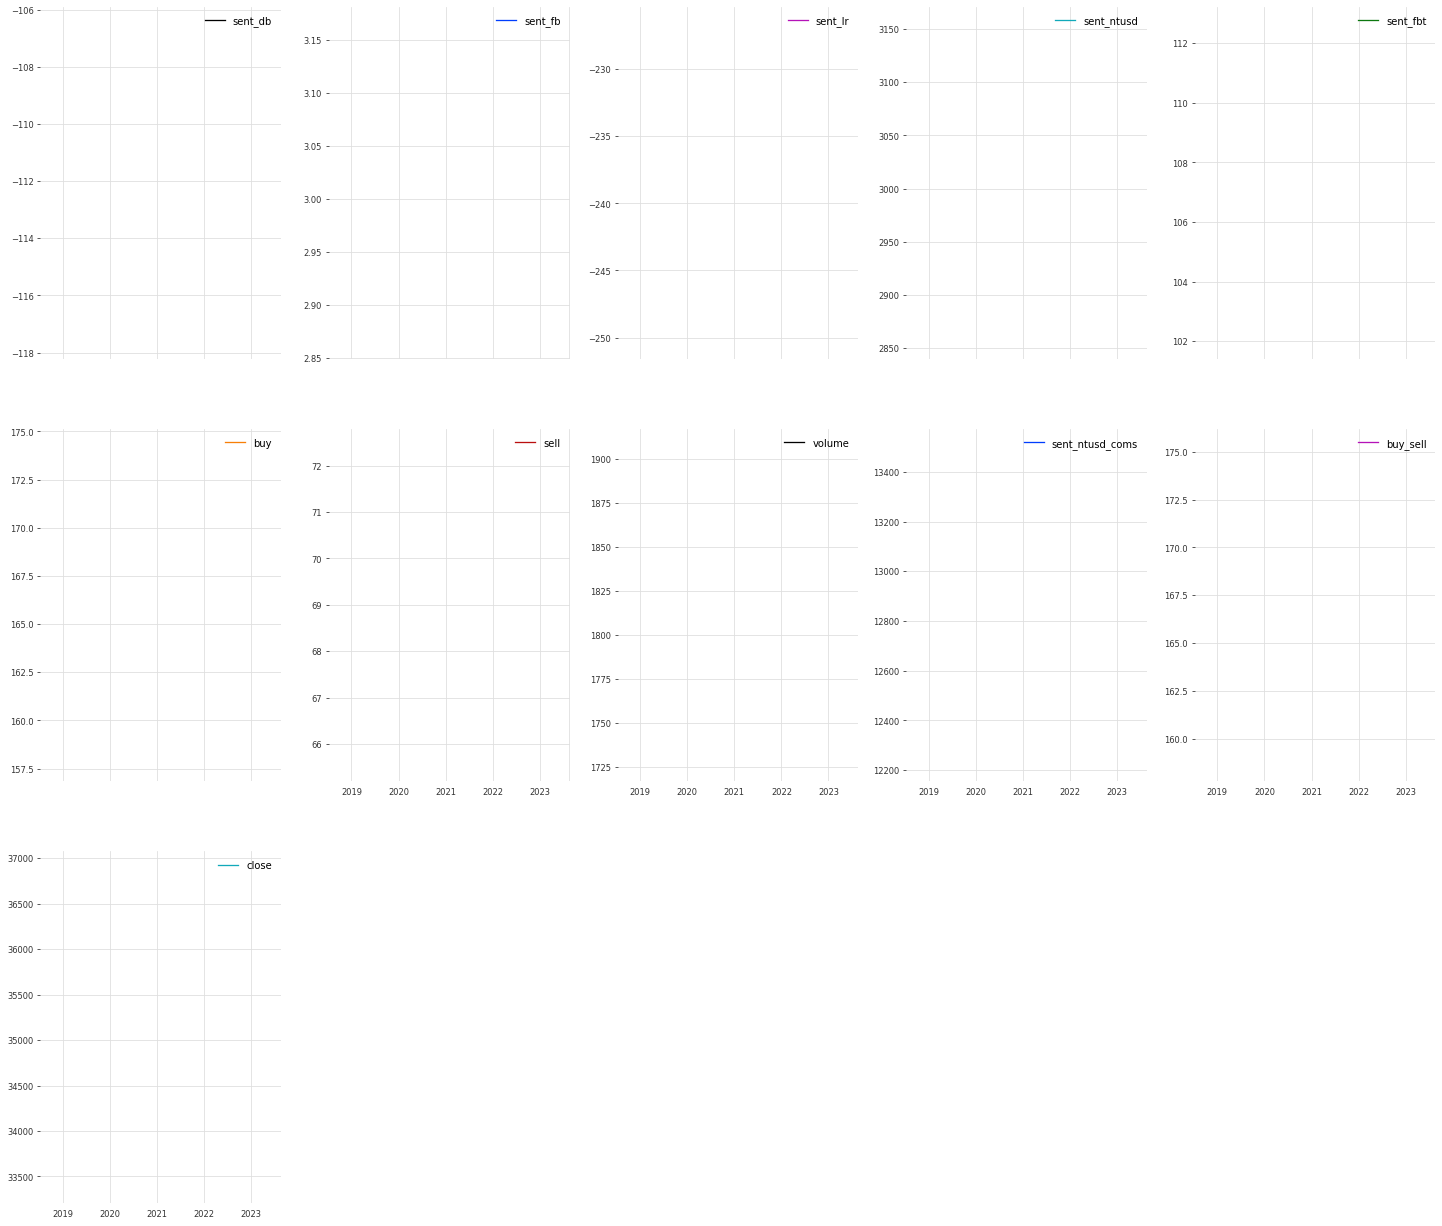

In [136]:
a['2021-01-29':'2021-01-29'][features].dropna().plot(subplots=True, layout=(3,5),figsize=(25,22))
plt.show()

In [182]:
series_start=   '2021-02-25'
split_date=     '2021-03-10'
series_end=     '2021-03-13'

resample_period='d'
s1=bdf.sent_db.resample(resample_period).sum()
s2=bdf.sent_fb.resample(resample_period).sum()
s3=bdf.sent_lr.resample(resample_period).sum()
s4=bdf.sent_ntusd.resample(resample_period).sum()
s5=bdf.sent_fbt.resample(resample_period).sum()
s6=bdf.buy.resample(resample_period).sum()
s7=bdf.sell.resample(resample_period).sum()
s8=bdf.volume.resample(resample_period).sum()
s9=bdf.sent_ntusd_coms.resample(resample_period).sum()
s10=bdf.buy_sell.resample(resample_period).sum()

btcin=btc.resample(resample_period).mean()#.pct_change().dropna()

a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btcin],axis=1)
#a=a[~a.sent_fbt.isna()].head(-1)


a=a[series_start:series_end]
# Create a TimeSeries, specifying the time and value columns

series_btc = TimeSeries.from_dataframe(a.reset_index(), 'index', 'close')
# Create training and validation sets:
train_btc, val_btc = series_btc.split_after(pd.Timestamp(split_date))
future_prediction_period=len(val_btc)
transformer_btc = Scaler()
train_transformed_btc = transformer_btc.fit_transform(train_btc)
val_transformed_btc = transformer_btc.transform(val_btc)
series_transformed_btc = transformer_btc.transform(series_btc)

series_sent = TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_fbt')
# Create training and validation sets:
train_sent, val_sent = series_sent.split_after(pd.Timestamp(split_date))
future_prediction_period=len(val_sent)
transformer_sent = Scaler()
train_transformed_sent = transformer_sent.fit_transform(train_sent)
val_transformed_sent = transformer_sent.transform(val_sent)
series_transformed_sent = transformer_sent.transform(series_sent)



model_cov = BlockRNNModel(
    model='LSTM',
    n_rnn_layers=2, 
    #hidden_dim=20,
    dropout=0.2,
    batch_size=12,
    n_epochs=250,
    optimizer_kwargs={'lr': 0.001}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    #training_length=40,
    input_chunk_length=2,
    output_chunk_length=1,
    force_reset=True,
    save_checkpoints=True
    )

model_cov.fit(series=[train_transformed_btc,train_transformed_sent],
              #past_covariates=covariates,
              val_series=[val_transformed_btc,val_transformed_sent], 
              #val_past_covariates=covariates, 
              verbose=True)

  0%|          | 0/250 [00:00<?, ?it/s]

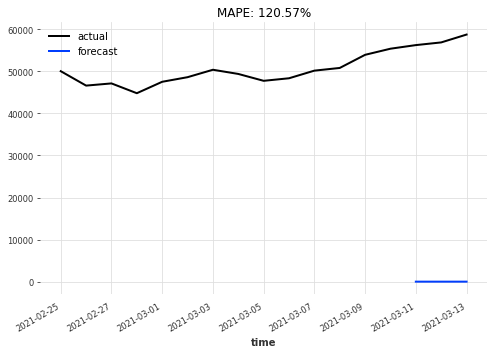

In [183]:
def eval_model(model):
    pred_series = model.predict(n=future_prediction_period,series=train_transformed_btc)
    plt.figure(figsize=(8,5))
    #series_transformed_btc[-len(pred_series):].plot(label='actual')
    series_btc.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed_btc)))
    plt.legend();


eval_model(model_cov)

<AxesSubplot:xlabel='datetime'>

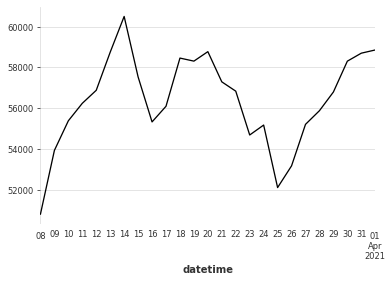

In [178]:
btc.resample(resample_period).mean()['2021-03-08':'2021-04-01'].close.plot()